In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from numba import cuda

data = pd.read_csv('countries-aggregated_csv.csv')

print(f'Cuda is available {cuda.is_available()}')

Cuda is available True


## Clustering part

Let's remove missing data from the dataset first

In [4]:
# Copying the original data and dropping the countries that don't have any recordings to their name.
mod_data = data.copy()
mod_data.replace(0, np.nan, inplace = True)
mod_data.dropna(inplace = True)
mod_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85912 entries, 61 to 143495
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       85912 non-null  object 
 1   Country    85912 non-null  object 
 2   Confirmed  85912 non-null  float64
 3   Recovered  85912 non-null  float64
 4   Deaths     85912 non-null  float64
dtypes: float64(3), object(2)
memory usage: 3.9+ MB


We will use **Kmeans** clustering algorithm and we will first try to figure out, which **k** is the best for the clustering.

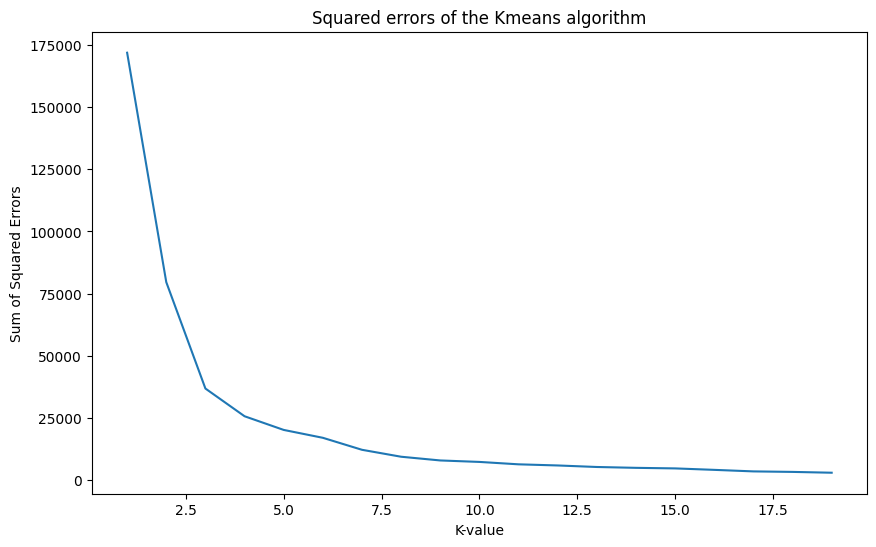

In [8]:
features = ['Recovered', 'Deaths']
scaler = StandardScaler()

# Data features
X = mod_data[features]

# Scaling the features, so that the clustering would work better
X_scaled = scaler.fit_transform(X)

# Squared error sums
sq_errors = []

N = 20
# The Elbow Method to find the best k parameter
for k in range(1, N):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    sq_errors.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, N), sq_errors)
plt.xlabel('K-value')
plt.ylabel('Sum of Squared Errors')
plt.title('Squared errors of the Kmeans algorithm')
plt.show()

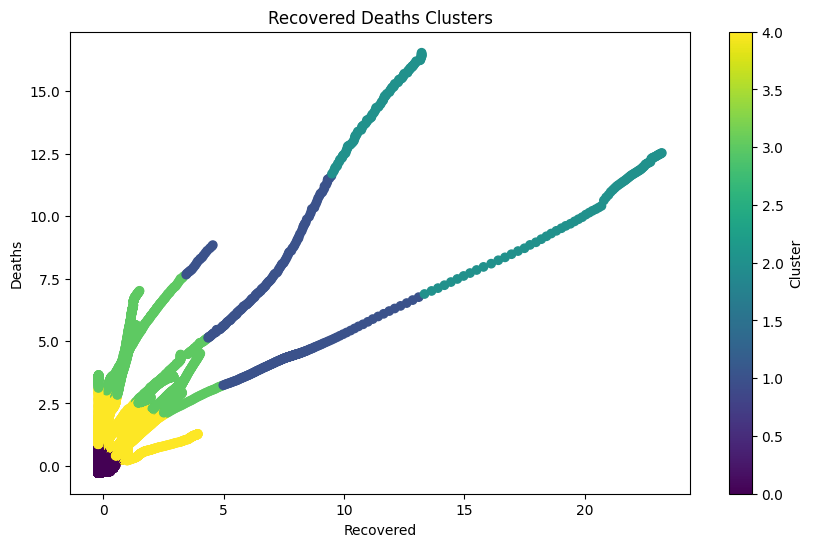

In [14]:
# # Getting the best k
# k_value = sq_errors.index(min(sq_errors))

# Setting up the clustering model
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans.fit(X_scaled)

# Predicting labels
labels = kmeans.predict(X_scaled)

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels, cmap='viridis', marker='o')
plt.xlabel('Recovered')
plt.ylabel('Deaths')
plt.title('Recovered Deaths Clusters')
plt.colorbar(label='Cluster')
plt.show()


As we can see that we cannot form clear clusters from this data currently. Let's try summing up all the Rcovered and Deaths data by Country and see if we can find more clear clusters.

In [21]:
country_data = mod_data.copy()
country_data = country_data.drop(['Date', 'Confirmed'], axis=1)
country_data = country_data.groupby('Country').sum().reset_index()
country_data.head()


,Country,Recovered,Deaths
0,Afghanistan,18289873.0,999952.0
1,Albania,22652652.0,540415.0
2,Algeria,25670233.0,1088600.0
3,Andorra,3085640.0,40615.0
4,Angola,5895800.0,176898.0


Let's try again if we can get more clear cluster plots.

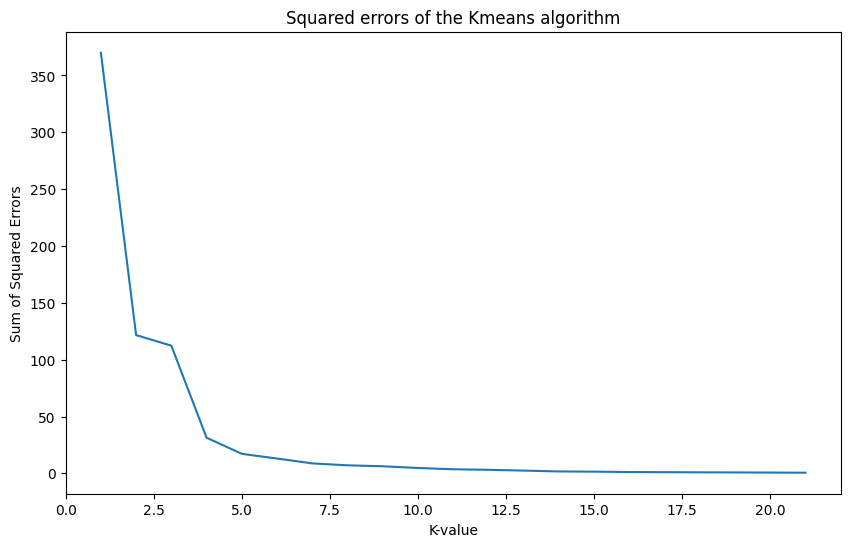

In [32]:
features = ['Recovered', 'Deaths']
scaler = StandardScaler()

# Data features
X = country_data[features]

# Scaling the features, so that the clustering would work better
X_scaled = scaler.fit_transform(X)

# Squared error sums
sq_errors = []

N = 22
# The Elbow Method to find the best k parameter
for k in range(1, N):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    sq_errors.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, N), sq_errors)
plt.xlabel('K-value')
plt.ylabel('Sum of Squared Errors')
plt.title('Squared errors of the Kmeans algorithm')
plt.show()

0.5565375770037924


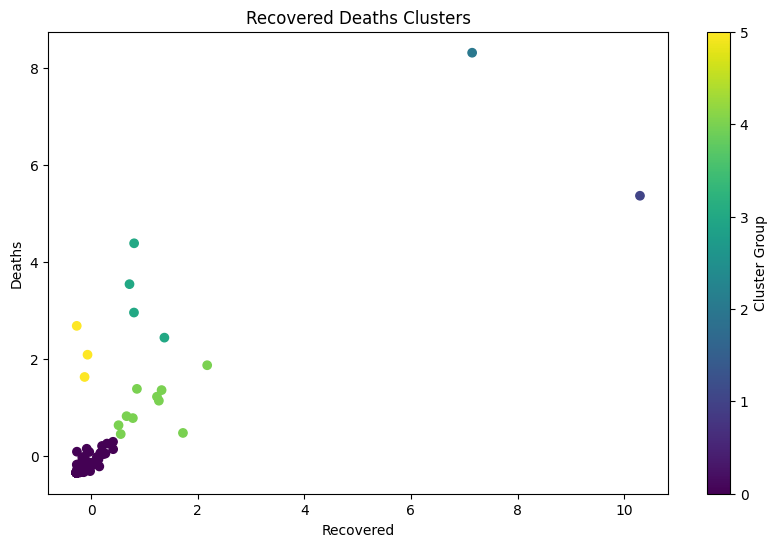

In [39]:
# # Getting the best k
k_value = sq_errors.index(min(sq_errors))
print(min(sq_errors))

# Setting up the clustering model
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans.fit(X_scaled)

# Predicting labels
labels = kmeans.predict(X_scaled)

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=labels, cmap='viridis', marker='o')
plt.xlabel('Recovered')
plt.ylabel('Deaths')
plt.title('Recovered Deaths Clusters')
plt.colorbar(label='Cluster Group')
plt.show()

Now we can see more clearly cluster groups and recognize that there are **two** outlier cluster groups and then **two to four** normal cluster groups. The Elbow method does not seem to work very well for these clusters, so we have to determine the cluster size for the model by hand.

We can see that countries that belong to **Navy** group have the highest recovery rate, but also the second highest death rate, which indicates that those countries have large populations and issues with Covid that might threaten the healthcare capabilities. Countries that belong to **Turquoise** group have the highest death rate and the second highest recovery rate, which also indicates large populations and worse issues with Covid handling than Navy group. Those countries probably already have healthcare capabilities overburdened and people are dying, because of that. Most countries belong to **Purple** group and have very low recovery and death rate, which indicates that the Covid-19 infections are very low in those countries and. **Green** group has 1:1 Recovery:Death rate, so in those countries there are recovery and death cases equally, but not too much to threat healthcare capabilities, unless it is a small country. **Yellow** group has semi high deaths and about zero recoveries, so those countries seem to have a non functioning healthcare systems. **Dark green** group has high death rate and low recovery rate, which indicates medium sized countries that have a lot of healthcare system issues.

Most of the countries belong to good groups that can handle Covid-19 very well, but there are some groups that have issues with their healthcare system or they do not have vaccinations to battle against the Covid-19.

Note: This cluster analysis gives us a very simple and a naive view of the real situation and the real world situation probably has a lot of nuances that this analysis does not take into account.